In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import os
import time
import sys
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, optimizers, layers, metrics, models, regularizers

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle("Data/df_final1.pkl")

In [3]:
df_lr = df.copy()

In [4]:
# Divide the predictor and target variables
X = df_lr.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                  "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee" ,"Rundvee"]]
y = df_lr["difference"]

In [5]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Apply linear regression and get predictions for the test set
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [7]:
# Calculate the RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [8]:
print(f"RMSE for all customers: {np.round(rmse, 2)}")

RMSE for all customers: 21.88


In [9]:
y_test.reset_index(drop=True, inplace=True)

In [10]:
# Generate the percent error for each order
percentages = []

for idx, val in enumerate(y_pred):
    perc = np.abs(val-y_test[idx])/y_test[idx]
    percentages.append(perc)

In [11]:
print(f"Minimum percent error: {np.round(np.min(percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(percentages),2)}")

Minimum percent error: 0.0
Maximum percent error: 25.48
Mean percent error: 1.06


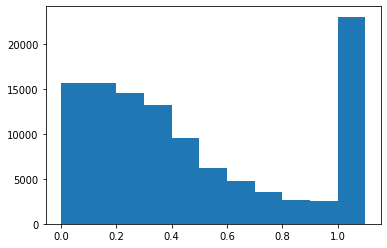

In [12]:
# Plot the distribution of percent errors
percentages = np.asarray(percentages)

plt.hist(percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [13]:
lower = []

for i in percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(percentages),2)}")

Number of orders with a percent error lower than 0.5: 68712
Percentage of orders with a percent error lower than 0.5: 0.62


In [14]:
# Create a list of the differences between the predicted difference and the actual difference
differences = []

for idx, val in enumerate(y_test):
    differences.append(np.abs(val-y_pred[idx]))

In [15]:
# Get percentages of orders predicted correctly within a specified number of days
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in differences]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in differences]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in differences]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in differences]

In [16]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(differences),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(differences),2)}")

Percentage of orders predicted correctly within 1 day: 0.11
Percentage of orders predicted correctly within 3 days: 0.27
Percentage of orders predicted correctly within 5 days: 0.43
Percentage of orders predicted correctly within 7 days: 0.56


In [17]:
df_new = pd.read_pickle("Data/df_with_history_>10_orders.pkl")

In [18]:
# Create a new list of customers
recipients_new = []

for i in df_new["recipient"]:
    if i not in recipients_new:
        recipients_new.append(i)
        
print(len(recipients_new))

3600


In [19]:
# For each customer, train linear regression, generate predictions, calculate the RMSE, get the percent errors,
# and get the differences between predicted and actual values
rmse_values = []
final_percentages = []
final_differences = []

for i in recipients_new:
    test = df_new[df_new.recipient == i]
    percentages = []
    differences = []
    
    X = test.loc[:, ["prev_date", "kg_ordered", "prod_group", "silo_nr", "kg_delivered",
                      "RU Geit", "RU Grond", "RU Kalv", "RU Melkv", "RU Vlvee" ,"Rundvee"]]
    y = test["difference"]
    
    X_train = X[0:-5]
    X_test = X[-5:]
    y_train = y[0:-5]
    y_test = y[-5:]
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    rmse_values.append(rmse)
    
    y_test.reset_index(drop=True, inplace=True)
    
    for idx, val in enumerate(y_pred):
        perc = np.abs(val-y_test[idx])/y_test[idx]
        percentages.append(perc)
    
    final_percentages.append(np.mean(percentages))

    for idx, val in enumerate(y_test):
        differences.append(np.abs(val-y_pred[idx]))
        
    final_differences.append(differences)

In [20]:
print(f"Mean of the mean RMSE per customer: {np.round(np.mean(rmse_values),2)}.")
print(f"Smallest mean RMSE: {np.round(np.min(rmse_values),2)}.")
print(f"Largest mean RMSE: {np.round(np.max(rmse_values),2)}.")

Mean of the mean RMSE per customer: 19.65.
Smallest mean RMSE: 0.41.
Largest mean RMSE: 6418.57.


In [21]:
print(f"Mean of the mean RMSE per customer, without the 150 largest values: {np.round(np.average(sorted(rmse_values)[0:-150]),2)}.")

Mean of the mean RMSE per customer, without the 150 largest values: 11.2.


In [22]:
rmse_values_array = np.asarray(rmse_values)

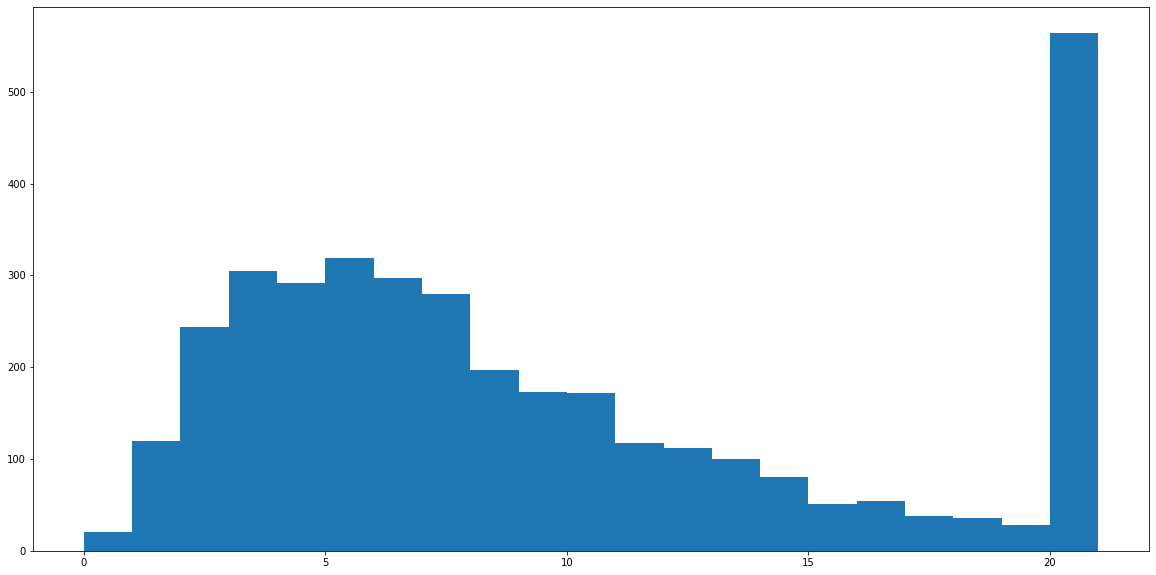

In [23]:
# Plot the distribution of mean RMSE values per customer
plt.figure(figsize=(20,10))

plt.hist(rmse_values_array.clip(min=0, max=21), range=[0,21], bins=21)
plt.show()

In [24]:
lower = []

for i in rmse_values:
    if i <= 5:
        lower.append(i)

print(f"Number of customers with an RMSE lower than 5: {len(lower)}")
print(f"Percentage of customer with an RMSE lower than 5: {np.round(len(lower)/len(rmse_values),2)}")

Number of customers with an RMSE lower than 5: 982
Percentage of customer with an RMSE lower than 5: 0.27


In [25]:
print(f"Minimum percent error: {np.round(np.min(final_percentages),2)}")
print(f"Maximum percent error: {np.round(np.max(final_percentages),2)}")
print(f"Mean percent error: {np.round(np.mean(final_percentages),2)}")

Minimum percent error: 0.02
Maximum percent error: 53.35
Mean percent error: 0.92


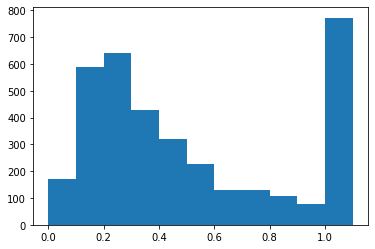

In [26]:
final_percentages = np.asarray(final_percentages)

plt.hist(final_percentages.clip(min=0, max=1.1), range=[0,1.1], bins=11)
plt.show()

In [27]:
lower = []

for i in final_percentages:
    if i <= 0.5:
        lower.append(i)

print(f"Number of orders with a percent error lower than 0.5: {len(lower)}")
print(f"Percentage of orders with a percent error lower than 0.5: {np.round(len(lower)/len(final_percentages),2)}")

Number of orders with a percent error lower than 0.5: 2153
Percentage of orders with a percent error lower than 0.5: 0.6


In [28]:
# Get the mean difference for each customer and add them to a list
final_diffs = [np.mean(lst) for lst in final_differences]

In [29]:
# Get percentages of orders predicted correctly within a specified number of days for the per-customer differences
within_1 = [1 if np.round(diff) <= 1 else 0 for diff in final_diffs]
within_3 = [1 if np.round(diff) <= 3 else 0 for diff in final_diffs]
within_5 = [1 if np.round(diff) <= 5 else 0 for diff in final_diffs]
within_7 = [1 if np.round(diff) <= 7 else 0 for diff in final_diffs]

In [30]:
print(f"Percentage of orders predicted correctly within 1 day: {np.round(np.sum(within_1)/len(final_diffs),2)}")
print(f"Percentage of orders predicted correctly within 3 days: {np.round(np.sum(within_3)/len(final_diffs),2)}")
print(f"Percentage of orders predicted correctly within 5 days: {np.round(np.sum(within_5)/len(final_diffs),2)}")
print(f"Percentage of orders predicted correctly within 7 days: {np.round(np.sum(within_7)/len(final_diffs),2)}")

Percentage of orders predicted correctly within 1 day: 0.03
Percentage of orders predicted correctly within 3 days: 0.2
Percentage of orders predicted correctly within 5 days: 0.41
Percentage of orders predicted correctly within 7 days: 0.57
